In [1]:
%load_ext autoreload
%autoreload 2
from innolux import *

In [224]:
class SealAnalysis:
    class Table:
        @staticmethod
        def generate_delta_table(df: pl.DataFrame, condition: str | None = None, test_ordinal=None, rms_cutoff=1) -> pl.DataFrame:
            delta_gap = {
                "Condition": [],
                "ID": [],
                "Location": [],
                "Class": [],
                "Delta(um)": [],
            }
            
            for glass_id in df['ID'].unique():
                delta_gap['ID'] += [glass_id] * 8
                delta_gap['Class'] += ['first - test value', 'test value - avg'] * 4
                if condition is None:
                    cond = df.filter(pl.col("ID") == glass_id)[0,'Condition']
                else:
                    cond = df.filter(pl.col("ID") == glass_id)[0,condition]
                delta_gap['Condition'] += [cond] * 8
                
                for location in ['up', 'down', 'left', 'right']:
                    tmp_df = df.filter(
                        pl.col('ID') == glass_id,
                        pl.col('Location') == location,
                        # (pl.col('Measure Order') % 20 > 4) | (pl.col('Measure Order') % 20 == 0),
                        pl.col('RMS(%)') < rms_cutoff,
                    )
                    first = tmp_df[0,3]
                    avg = tmp_df[-10:,3].mean()
                    if test_ordinal is not None:
                        test_index = test_ordinal[glass_id][location]
                        test_value = tmp_df[test_index,3]
                    else:  
                        test_value = tmp_df[:,3].max()
                    delta_gap['Location'] += [location] * 2
                    delta_gap['Delta(um)'] += [first - test_value, test_value - avg]                  
            
            return pl.DataFrame(delta_gap)
    class Plot:
        @staticmethod
        def around_gap(df: pl.DataFrame, **params):
            figs = []
            for cond in df['Condition'].unique():
                print(cond)
                figs.append(px.scatter(
                    df.filter(pl.col('Condition')==cond),
                    color_continuous_scale=px.colors.sequential.Jet,
                    # color_discrete_sequence=px.colors.sequential.Jet,
                    **params,
                ))
                figs[-1].update_layout(yaxis_range=(3.1, 3.5))
                figs[-1].show()
            return figs
        
        @staticmethod
        def around_delta(df: pl.DataFrame, **params):
            conds = df['Condition'].unique()
            fig = make_subplots(rows=1, cols=len(conds), shared_yaxes=True)
            for index, cond in enumerate(conds):
                print(cond)
                tmp_df = df.filter(pl.col('Condition')==cond)
                sub_fig = px.box(
                    tmp_df,
                    **params
                )
                for trace in sub_fig.data:
                    fig.add_trace(trace, row=1, col=index+1)
            return fig

In [6]:
# import plotly.io as pio 
# pio.renderers.default = "vscode" # fro vscode render

In [8]:
around_gap = pl.read_excel(data_path / "T2 6628 BP 3500 A ZIX-7061 S-NP13 S-WB141" / "around_gap_summary_20250903.xlsx")
around_gap

ID,Measure Order,Location,Cell Gap(um),Dist to Edge(mm),RMS(%),Panel ID,Condition,Cross Area,GRADE
str,i64,str,f64,i64,f64,str,str,str,str
"""210FB5""",0,"""center""",3.149687,0,0.248483,"""660L2AP50FN210FB5""","""LCT-15-1098 + S-WB141""","""2320""","""NG"""
"""210FB5""",1,"""up""",3.189865,0,0.773582,"""660L2AP50FN210FB5""","""LCT-15-1098 + S-WB141""","""2320""","""NG"""
"""210FB5""",2,"""up""",3.195987,1,0.239258,"""660L2AP50FN210FB5""","""LCT-15-1098 + S-WB141""","""2320""","""NG"""
"""210FB5""",3,"""up""",3.191534,2,0.231841,"""660L2AP50FN210FB5""","""LCT-15-1098 + S-WB141""","""2320""","""NG"""
"""210FB5""",4,"""up""",3.185135,3,0.253972,"""660L2AP50FN210FB5""","""LCT-15-1098 + S-WB141""","""2320""","""NG"""
…,…,…,…,…,…,…,…,…,…
"""215C96""",76,"""right""",3.235699,15,0.237454,"""660L2AP50FN215C96""","""ZIX-7061XX + S-WB141""","""2418""","""G1"""
"""215C96""",77,"""right""",3.235278,16,0.236192,"""660L2AP50FN215C96""","""ZIX-7061XX + S-WB141""","""2418""","""G1"""
"""215C96""",78,"""right""",3.235292,17,0.238952,"""660L2AP50FN215C96""","""ZIX-7061XX + S-WB141""","""2418""","""G1"""


In [24]:
around_gap.filter(pl.col("Panel ID") == "660L2AP50FN215C96")[0,'Condition']

'ZIX-7061XX + S-WB141'

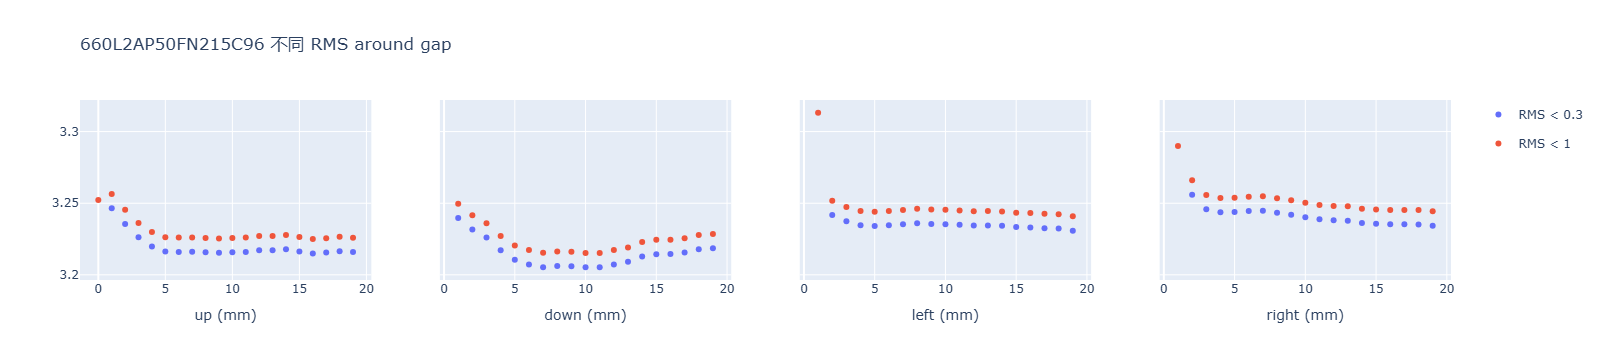

In [9]:
fig = make_subplots(rows=1, cols=4, shared_yaxes=True)
for index, loc in enumerate(['up', 'down', 'left', 'right']):
    tmp_df = pl.concat([
        around_gap.filter(
            pl.col("RMS(%)") < 0.3,
            pl.col('Location')==loc,
            pl.col("Panel ID") == "660L2AP50FN215C96",
        ).select(
            "Dist to Edge(mm)",
            "Cell Gap(um)",
            pl.col('Cell Gap(um)').abs().alias('d2'),
        ).with_columns(
            pl.lit("RMS < 0.3").alias('RMS cut-off')
        ),
        around_gap.filter(
            pl.col("RMS(%)") < 1,
            pl.col('Location')==loc,
            pl.col("Panel ID") == "660L2AP50FN215C96",
        ).select(
            "Dist to Edge(mm)",
            "Cell Gap(um)",
            (pl.col('Cell Gap(um)').abs() + 0.01).alias('d2'),
        ).with_columns(
            pl.lit("RMS < 1").alias('RMS cut-off')
        )
    ])
    sub_fig = px.scatter(
        tmp_df,
        x='Dist to Edge(mm)',
        y='d2',
        color='RMS cut-off',
    )

    for trace in sub_fig.data:
        if index != 0:
            trace['showlegend'] = False
        fig.add_trace(trace, row=1, col=index+1)
        fig.update_xaxes(title_text=f"{loc} (mm)", row=1, col=index+1)


fig.update_layout(title="660L2AP50FN215C96 不同 RMS around gap")
fig.show()

### 找反轉點

1. Fitting line (cubic spline or Savitzky-Golay Filter)
    1. Precise polynomials spline
        1. p=3 (to get second derivative, we need p >= 3), `CubicSpline.derivative(nu=2)` -> precise point, 沒有考慮噪點 
        2. p=4, `make_interp_spline(x, y, k=4)` -> 沒有考慮噪點 and overfitting
        -> using smoothing spline
    2. Smoothing spline
        1. 
2. Calculate the derivatives

3. Check root

In [170]:
around_gap.select('Panel ID').unique()

Panel ID
str
"""660L2AP50FN214B95"""
"""660L2AP50FN215BA5"""
"""660L2AP50FN215C96"""
"""660L2AP50FN210FL4"""
"""660L2AP50FN214BA4"""
…
"""660L2AP50FN214B85"""
"""660L2AP50FN214B53"""
"""660L2AP50FN215BA4"""


In [3]:
from ipywidgets import widgets
from IPython.display import display

w = widgets.IntSlider()
display(w)

IntSlider(value=0)

In [17]:
with out:
    display(panel_id)

In [18]:
out.clear_output()

In [20]:
a = widgets.IntSlider(description='a')
b = widgets.IntSlider(description='b')
c = widgets.IntSlider(description='c')
def f(a, b, c):
    print('{}*{}*{}={}'.format(a, b, c, a*b*c))

out = widgets.interactive_output(f, {'a': a, 'b': b, 'c': c})

widgets.HBox([widgets.VBox([a, b, c]), out])

In [10]:
panel_id = widgets.Dropdown(
    options=around_gap['Panel ID'].unique(),
    value='660L2AP50FN214B95',
    description='Panel ID: ',
    disabled=False,
)
display(panel_id)

Dropdown(description='Panel ID: ', index=16, options=('660L2AP50FN215BA5', '660L2AP50FN214B63', '660L2AP50FN21…

infection point: 1


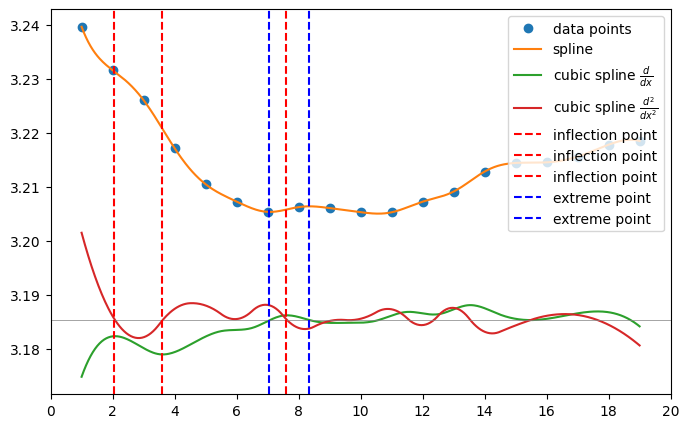

In [98]:
from scipy.interpolate import make_interp_spline, make_smoothing_spline, make_splrep
from ipywidgets import widgets
from IPython.display import display
# %matplotlib widget

# panel_id = widgets.Dropdown(
#     options=around_gap['Panel ID'].unique(),
#     value='660L2AP50FN214B95',
#     description='Panel ID: ',
#     disabled=False,
# )
# locaction = widgets.Dropdown(
#     options=around_gap['Location'].unique(),
#     value='up',
#     description='Location: ',
#     disabled=False,
# )

# test data
test_df = around_gap.filter(
    pl.col("RMS(%)") < 0.3,
    pl.col('Location')=='down',
    pl.col("Panel ID") == "660L2AP50FN215C96",
    # pl.col("Panel ID") == "660L2AP50FN210FB5",
).select(
    "Dist to Edge(mm)",
    "Cell Gap(um)",
)

x = test_df['Dist to Edge(mm)'].to_numpy()
y = test_df['Cell Gap(um)'].to_numpy()

# cs = CubicSpline(x,y)
# spline = make_splrep(x,y,k=3,s=20)
# spline = make_smoothing_spline(x,y,lam=0.2)
spline = make_interp_spline(x,y, k=4)
xx = np.linspace(x.min(), x.max(), 500)

d1 = spline(xx, 1)
d2 = spline(xx, 2)

sign_changes = np.where(np.diff(np.sign(d2)) != 0)[0]
inflection_points = xx[sign_changes]

d1_sign_changes = np.where(np.diff(np.sign(d1)) != 0)[0]
extreme_points = xx[d1_sign_changes]

# plot

base_line = np.min(y) - 0.02
multiply = np.max(y) / np.max(np.abs(d2)) / 200
# plt.ioff()

fig, ax = plt.subplots(figsize=(8,5))
ax.plot(x, y, 'o', label="data points")
ax.plot(xx, spline(xx), label='spline')
ax.plot(xx, d1 * multiply + base_line, label=r'cubic spline $\frac{d}{dx}$')
ax.plot(xx, d2 * multiply + base_line, label=r'cubic spline $\frac{d^2}{dx^2}$')
ax.axhline(base_line, color='gray', lw=0.5)
ax.axvline(inflection_points[0], color="red", linestyle='--', label="inflection point")
ax.axvline(inflection_points[1], color="red", linestyle='--', label="inflection point")
ax.axvline(inflection_points[2], color="red", linestyle='--', label="inflection point")
ax.axvline(extreme_points[0], color="blue", linestyle='--', label="extreme point")
ax.axvline(extreme_points[1], color="blue", linestyle='--', label="extreme point")

ax.set_xlim(0, 20)
ax.set_xticks(np.arange(0, 21, 2))
ax.legend()
print(f"infection point: {np.argmin(np.abs(x - inflection_points[0]))}")

plt.show()

In [156]:
from scipy.interpolate import make_interp_spline, make_smoothing_spline, make_splrep
from ipywidgets import interact

def get_inflection_points(panel_id, location, rms_cutoff):
    test_df = around_gap.filter(
        pl.col("RMS(%)") < rms_cutoff,
        pl.col('Location') == location,
        pl.col("Panel ID") == panel_id,
        # pl.col("Panel ID") == "660L2AP50FN210FB5",
    ).select(
        "Dist to Edge(mm)",
        "Cell Gap(um)",
    )
    
    x = test_df['Dist to Edge(mm)'].to_numpy()
    y = test_df['Cell Gap(um)'].to_numpy()
    
    # spline = make_splrep(x,y,k=4,s=20)
    spline = make_smoothing_spline(x,y,lam=0.2)
    # spline = make_interp_spline(x,y,k=4)
    xx = np.linspace(x.min(), x.max(), 500)
    
    d1 = spline(xx, 1)
    d2 = spline(xx, 2)
    
    sign_changes = np.where(np.diff(np.sign(d2)) != 0)[0]
    inflection_points = xx[sign_changes]

    d1_sign_changes = np.where(np.diff(np.sign(d1)) != 0)[0]
    extreme_points = xx[d1_sign_changes]

    # d2 diff cut-off: 0.0025
    d2_diff_cutoff = np.where(np.abs(d2) < 0.0025)[0]
    d2_diff_cutoff_points = xx[d2_diff_cutoff]

    # test line d1 < 0.005, d2 < 0.005
    test_condition = np.where((np.abs(d1) < 0.0025) & (np.abs(d2) < 0.005))[0]
    test_points = xx[test_condition]
    
    # plot
    
    base_line = np.min(y) - 0.005
    # multiply = np.max(y) / np.max(np.abs(d2)) / 200
    multiply = 1
    
    fig, ax = plt.subplots(figsize=(8,5))
    ax.plot(x, y, 'o', label="data points")
    ax.plot(xx, spline(xx), label='spline(f)')
    ax.plot(xx, d1 * multiply + base_line, label=r'$\frac{d}{dx}f$')
    ax.plot(xx, d2 * multiply + base_line, label=r'$\frac{d^2}{dx^2}f$')
    ax.axhline(base_line, color='gray', lw=0.5)

    # for idx, inflection_point in enumerate(inflection_points):
    #     if idx > 1: break
    #     if idx == 0:
    #         ax.axvline(inflection_point, color="red", linestyle='--', label="inflection")
    #     else:
    #         ax.axvline(inflection_point, color="red", linestyle='--')
        
        
    # for idx, extreme_point in enumerate(extreme_points):
    #     if idx > 1: break
    #     if idx == 0:
    #         ax.axvline(extreme_point, color="blue", linestyle='--', label="extreme point")
    #     else:
    #         ax.axvline(extreme_point, color="blue", linestyle='--')

    # for idx, d2_diff_cutoff_point in enumerate(d2_diff_cutoff_points):
    #     if idx > 1: break
    #     ax.axvline(d2_diff_cutoff_point, color="green", linestyle='--', label="d2 cut off point")

    for idx, test_point in enumerate(test_points):
        if idx > 0: break
        if idx == 0:
            ax.axvline(test_point, color="green", linestyle='--', label=r"$\frac{d}{dx}f < 0.0025 \wedge \frac{d^2}{dx^2}f < 0.005$")
        else:
            ax.axvline(test_point, color="green", linestyle=':')
            
    ax.set_xlim(0, 20)
    ax.set_xticks(np.arange(0, 21, 2))
    ax.legend(loc='upper right')
    if len(test_points) > 0:
        print(f"target point: {np.argmin(np.abs(x - test_points[0]))}")
    
    plt.show()

interact(
    get_inflection_points, 
    panel_id=around_gap['Panel ID'].unique().sort(),
    location=['up', 'down', 'left', 'right'],
    rms_cutoff=[1, 0.3]
)

interactive(children=(Dropdown(description='panel_id', options=('660L2AP50FN210FB5', '660L2AP50FN210FC4', '660…

<function __main__.get_inflection_points(panel_id, location, rms_cutoff)>

In [164]:
d2[0]

np.float64(1.7763568394002505e-15)

In [246]:
rms_cutoff = 1

target_ordinals = {}
target_df_dict = {
    "Condition": [],
    "ID": [],
    "Location": [],
    "Ordinal": [],
    "Dist to Edge(mm)": [],
}
for panel_id in around_gap['ID'].unique():
    target_ordinals[panel_id] = {}
    for location in ['up', 'down', 'left', 'right']:
        test_df = around_gap.filter(
            pl.col("RMS(%)") < rms_cutoff,
            pl.col('Location') == location,
            # pl.col("Panel ID") == panel_id,
            pl.col("ID") == panel_id
            # pl.col("Panel ID") == "660L2AP50FN215C96",
            # pl.col("Panel ID") == "660L2AP50FN210FB5",
        ).select(
            'Condition',
            "Dist to Edge(mm)",
            "Cell Gap(um)",
        )
        
        x = test_df['Dist to Edge(mm)'].to_numpy()
        y = test_df['Cell Gap(um)'].to_numpy()
        
        spline = make_smoothing_spline(x,y,lam=0.2)
        # spline = make_interp_spline(x,y)
        xx = np.linspace(x.min(), x.max(), 500)

        d1 = spline(xx, 1)
        d2 = spline(xx, 2)
        
        test_condition = np.where((np.abs(d1) < 0.0025) & (np.abs(d2) < 0.005))[0]
        test_points = xx[test_condition]
        if len(test_points) > 0:
            target_ordinal = np.argmin(np.abs(x - test_points[0]))
        else:
            target_ordinal = 0
        target_ordinals[panel_id][location] = int(target_ordinal)
        target_df_dict['Condition'].append(test_df[0,0])
        target_df_dict["ID"].append(panel_id)
        target_df_dict['Location'].append(location)
        target_df_dict['Ordinal'].append(target_ordinal)
        target_df_dict['Dist to Edge(mm)'].append(float(x[target_ordinal]))


In [240]:
target_ordinals

{'214B95': {'up': 4, 'down': 5, 'left': 1, 'right': 1},
 '214B85': {'up': 0, 'down': 3, 'left': 1, 'right': 1},
 '215BA5': {'up': 4, 'down': 5, 'left': 2, 'right': 3},
 '214B75': {'up': 0, 'down': 3, 'left': 2, 'right': 1},
 '210FC4': {'up': 5, 'down': 5, 'left': 3, 'right': 5},
 '214BA4': {'up': 3, 'down': 4, 'left': 2, 'right': 3},
 '214B63': {'up': 3, 'down': 0, 'left': 1, 'right': 1},
 '214B84': {'up': 3, 'down': 4, 'left': 1, 'right': 2},
 '215B54': {'up': 4, 'down': 5, 'left': 2, 'right': 2},
 '215C96': {'up': 4, 'down': 5, 'left': 2, 'right': 2},
 '210FB5': {'up': 5, 'down': 5, 'left': 2, 'right': 2},
 '210GL6': {'up': 5, 'down': 5, 'left': 3, 'right': 0},
 '210FL5': {'up': 6, 'down': 5, 'left': 1, 'right': 16},
 '215B95': {'up': 5, 'down': 5, 'left': 2, 'right': 2},
 '215BA4': {'up': 5, 'down': 5, 'left': 2, 'right': 3},
 '210FF4': {'up': 6, 'down': 5, 'left': 3, 'right': 3},
 '214B53': {'up': 3, 'down': 0, 'left': 2, 'right': 2},
 '210FL4': {'up': 4, 'down': 5, 'left': 0, 'rig

In [247]:
target_ordinals_df = pl.DataFrame(target_df_dict)

In [232]:
target_ordinals_df

Condition,ID,Location,Ordinal,Dist to Edge(mm)
str,str,str,i64,f64
"""ZIX-7061XX + S-NP13""","""214BA4""","""up""",3,4.0
"""ZIX-7061XX + S-NP13""","""214BA4""","""down""",4,5.0
"""ZIX-7061XX + S-NP13""","""214BA4""","""left""",3,4.0
"""ZIX-7061XX + S-NP13""","""214BA4""","""right""",3,4.0
"""LCT-15-1098 + S-WB141""","""210FL4""","""up""",5,5.0
…,…,…,…,…
"""ZIX-7061XX + S-WB141""","""215B95""","""right""",3,4.0
"""ZIX-7061XX + S-NP13""","""214B63""","""up""",3,4.0
"""ZIX-7061XX + S-NP13""","""214B63""","""down""",0,1.0


In [248]:
target_ordinals_mode = target_ordinals_df.pivot(
    on="Location",
    index='Condition',
    values='Ordinal',
    aggregate_function=pl.element().mode().mean().round()
)
target_ordinals_mode

Condition,up,down,left,right
str,f64,f64,f64,f64
"""ZIX-7061XX + S-NP13""",3.0,4.0,3.0,2.0
"""LCT-15-1098 + S-WB141""",5.0,5.0,3.0,6.0
"""ZIX-7061XX + S-WB141""",5.0,5.0,3.0,3.0


In [249]:
modified_target_ordinals = {}
for panel_id, v in target_ordinals.items():
    modified_target_ordinals[panel_id] = {}
    condition = target_ordinals_df.filter(pl.col('ID') == panel_id).select('Condition')[0,0]
    for location, origin_ordinal in v.items():
        mode = target_ordinals_mode.filter(pl.col('Condition') == condition).select(location)[0,0]
        if np.abs(origin_ordinal - mode) > 1:
            modified_target_ordinals[panel_id][location] = int(mode)
        else:
            modified_target_ordinals[panel_id][location] = int(origin_ordinal)

modified_target_ordinals

{'214B75': {'up': 3, 'down': 4, 'left': 3, 'right': 2},
 '210FC4': {'up': 5, 'down': 5, 'left': 4, 'right': 5},
 '210FB5': {'up': 5, 'down': 5, 'left': 3, 'right': 6},
 '210FF4': {'up': 5, 'down': 5, 'left': 4, 'right': 6},
 '215BA5': {'up': 5, 'down': 5, 'left': 3, 'right': 3},
 '214B63': {'up': 3, 'down': 4, 'left': 3, 'right': 2},
 '215C96': {'up': 5, 'down': 5, 'left': 3, 'right': 3},
 '210FL4': {'up': 5, 'down': 5, 'left': 2, 'right': 6},
 '215BA4': {'up': 5, 'down': 6, 'left': 3, 'right': 3},
 '214B84': {'up': 3, 'down': 4, 'left': 3, 'right': 3},
 '214B95': {'up': 3, 'down': 5, 'left': 3, 'right': 2},
 '214B85': {'up': 3, 'down': 4, 'left': 3, 'right': 2},
 '215B54': {'up': 5, 'down': 5, 'left': 3, 'right': 3},
 '214BA4': {'up': 3, 'down': 4, 'left': 3, 'right': 3},
 '215B95': {'up': 6, 'down': 5, 'left': 3, 'right': 3},
 '214B53': {'up': 4, 'down': 4, 'left': 3, 'right': 3},
 '210FL5': {'up': 5, 'down': 5, 'left': 2, 'right': 6},
 '210GL6': {'up': 5, 'down': 5, 'left': 3, 'righ

In [237]:
target_ordinals

{'214BA4': {'up': 3, 'down': 4, 'left': 3, 'right': 3},
 '210FL4': {'up': 5, 'down': 5, 'left': 2, 'right': 9},
 '215BA4': {'up': 5, 'down': 6, 'left': 3, 'right': 3},
 '214B85': {'up': 1, 'down': 4, 'left': 3, 'right': 2},
 '215BA5': {'up': 5, 'down': 5, 'left': 3, 'right': 3},
 '210FL5': {'up': 7, 'down': 5, 'left': 2, 'right': 16},
 '210GL6': {'up': 5, 'down': 5, 'left': 3, 'right': 0},
 '214B75': {'up': 0, 'down': 4, 'left': 3, 'right': 2},
 '214B84': {'up': 3, 'down': 4, 'left': 3, 'right': 3},
 '210FF4': {'up': 7, 'down': 5, 'left': 4, 'right': 3},
 '215C96': {'up': 0, 'down': 5, 'left': 3, 'right': 3},
 '210FB5': {'up': 1, 'down': 5, 'left': 3, 'right': 2},
 '215B54': {'up': 5, 'down': 5, 'left': 3, 'right': 3},
 '210FC4': {'up': 5, 'down': 5, 'left': 4, 'right': 5},
 '214B95': {'up': 5, 'down': 5, 'left': 3, 'right': 2},
 '214B53': {'up': 4, 'down': 0, 'left': 3, 'right': 3},
 '215B95': {'up': 6, 'down': 5, 'left': 3, 'right': 3},
 '214B63': {'up': 3, 'down': 0, 'left': 3, 'rig

LCT-15-1098 + S-WB141
ZIX-7061XX + S-NP13
ZIX-7061XX + S-WB141


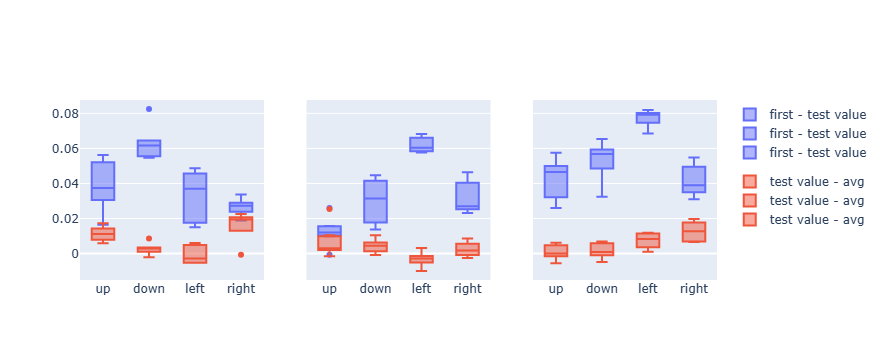

In [250]:
# rms cut off = 1
fig = SealAnalysis.Plot.around_delta(
    SealAnalysis.Table.generate_delta_table(around_gap, test_ordinal=modified_target_ordinals).sort('Condition'),
    x='Location',
    y='Delta(um)',
    color='Class',
)
fig.show()

LCT-15-1098 + S-WB141
ZIX-7061XX + S-WB141
ZIX-7061XX + S-NP13


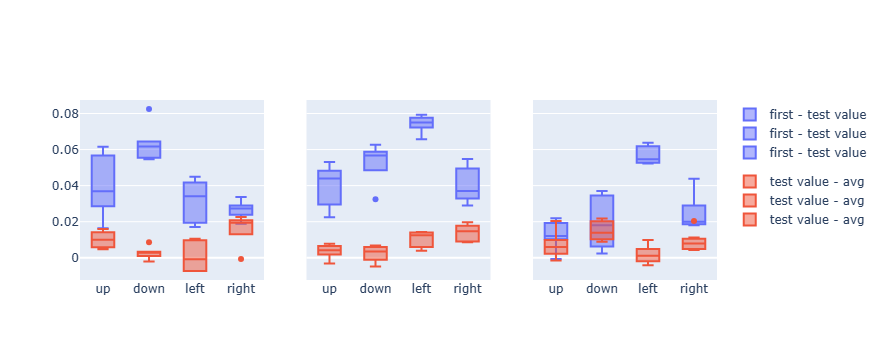

In [245]:
# rms cut off = 0.3
fig = SealAnalysis.Plot.around_delta(
    SealAnalysis.Table.generate_delta_table(around_gap, test_ordinal=modified_target_ordinals).sort('Condition'),
    x='Location',
    y='Delta(um)',
    color='Class',
)
fig.show()

In [47]:
fig = SealAnalysis.Plot.around_gap(
    around_gap.filter(pl.col("RMS(%)") < 1), # RMS < 0.3 -> no large jump point
    x='Measure Order',
    y='Cell Gap(um)',
    color='GRADE',
)

ZIX-7061XX + S-NP13


ZIX-7061XX + S-WB141


LCT-15-1098 + S-WB141


In [168]:
df = around_gap.filter(pl.col("RMS(%)") < 1)
params = {
    "x": 'Measure Order',
    "y": 'Cell Gap(um)',
    "color": 'GRADE',
    "hover_data": 'Panel ID',
}

figs = []
for cond in df['Condition'].unique():
    print(cond)
    figs.append(px.scatter(
        df.filter(pl.col('Condition')==cond),
        color_continuous_scale=px.colors.sequential.Jet,
        # color_discrete_sequence=px.colors.sequential.Jet,
        **params,
    ))
    figs[-1].update_layout(yaxis_range=(3.1, 3.5))
    figs[-1].show()

LCT-15-1098 + S-WB141


ZIX-7061XX + S-WB141


ZIX-7061XX + S-NP13


In [39]:
around_gap


ID,Measure Order,Location,Cell Gap(um),Dist to Edge(mm),RMS(%),Panel ID,Condition,Cross Area,GRADE
str,i64,str,f64,i64,f64,str,str,str,str
"""210FB5""",0,"""center""",3.149687,0,0.248483,"""660L2AP50FN210FB5""","""LCT-15-1098 + S-WB141""","""2320""","""NG"""
"""210FB5""",1,"""up""",3.189865,0,0.773582,"""660L2AP50FN210FB5""","""LCT-15-1098 + S-WB141""","""2320""","""NG"""
"""210FB5""",2,"""up""",3.195987,1,0.239258,"""660L2AP50FN210FB5""","""LCT-15-1098 + S-WB141""","""2320""","""NG"""
"""210FB5""",3,"""up""",3.191534,2,0.231841,"""660L2AP50FN210FB5""","""LCT-15-1098 + S-WB141""","""2320""","""NG"""
"""210FB5""",4,"""up""",3.185135,3,0.253972,"""660L2AP50FN210FB5""","""LCT-15-1098 + S-WB141""","""2320""","""NG"""
…,…,…,…,…,…,…,…,…,…
"""215C96""",76,"""right""",3.235699,15,0.237454,"""660L2AP50FN215C96""","""ZIX-7061XX + S-WB141""","""2418""","""G1"""
"""215C96""",77,"""right""",3.235278,16,0.236192,"""660L2AP50FN215C96""","""ZIX-7061XX + S-WB141""","""2418""","""G1"""
"""215C96""",78,"""right""",3.235292,17,0.238952,"""660L2AP50FN215C96""","""ZIX-7061XX + S-WB141""","""2418""","""G1"""


ZIX-7061XX + S-WB141
ZIX-7061XX + S-NP13
LCT-15-1098 + S-WB141


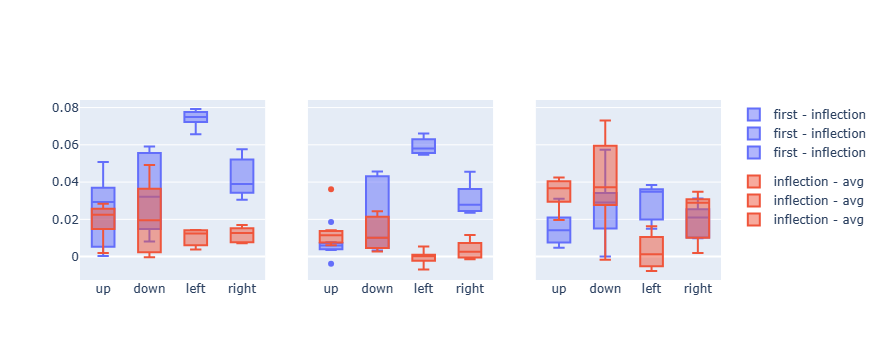

In [66]:
fig = SealAnalysis.Plot.around_delta(
    SealAnalysis.Table.generate_delta_table(around_gap,inflection_point=inflection_ordinals),
    x='Location',
    y='Delta(um)',
    color='Class',
)
fig.show()

In [34]:
df = SealAnalysis.Table.generate_delta_table(around_gap)
params = {
    "x":'Location',
    "y":'Delta(um)',
    "color":'Class',
}
conds = df['Condition'].unique()
fig = make_subplots(rows=1, cols=len(conds), shared_yaxes=True)
for index, cond in enumerate(conds):
    print(cond)
    tmp_df = df.filter(pl.col('Condition')==cond)
    sub_fig = px.box(
        tmp_df,
        **params
    )
    for trace in sub_fig.data:
        fig.add_trace(trace, row=1, col=index+1)
fig.show()

ZIX-7061XX + S-NP13
LCT-15-1098 + S-WB141
ZIX-7061XX + S-WB141
